## Part 2: Clean the data

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import shapely
from IPython.core.pylabtools import figsize
figsize(8,8)

C:\Users\abeme\AppData\Local\Temp\ipykernel_14496\4075035834.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# data: boros, commuity districts, fresh stores, fresh zones, brooklyn census info

In [4]:
# load boundaries and FRESH stores data (FRESH zones will be added later)
#boros
url_bb = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
boros = gpd.read_file(url_bb)

#community districts 
url_cd = "https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=Shapefile"
cds = gpd.read_file(url_cd)

# FRESH stores
fresh_stores = gpd.read_file('../data/transformed/fresh_stores.geojson')

In [5]:
# load the census data
mhhi_19 = gpd.read_file("../data/transformed/bk_19_median_hhi_clip.geojson")
mhhi_11 = gpd.read_file("../data/transformed/bk_11_median_hhi_clip.geojson")
tot_pop_19 = gpd.read_file("../data/transformed/tot_pop_19_clip.geojson")
tot_pop_11 = gpd.read_file("../data/transformed/tot_pop_11_clip.geojson")                           
yt_19 = gpd.read_file("../data/transformed/yt_19_clipped.geojson")
yt_11 = gpd.read_file("../data/transformed/yt_11_clipped.geojson")
built_19 = gpd.read_file("../data/transformed/built_19_clipped.geojson")

#### Filter to Brooklyn & Bed-Stuy extents, with ESPG: 4326

#### part I: brooklyn extent in boros

In [6]:
# where boro_name = "Brooklyn"
boros = boros.to_crs(4326)
boros

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1.0,Manhattan,6.365208e+08,357564.316391,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3.0,Brooklyn,1.934143e+09,728197.541089,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4.0,Queens,3.041419e+09,888199.731579,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


<Axes: >

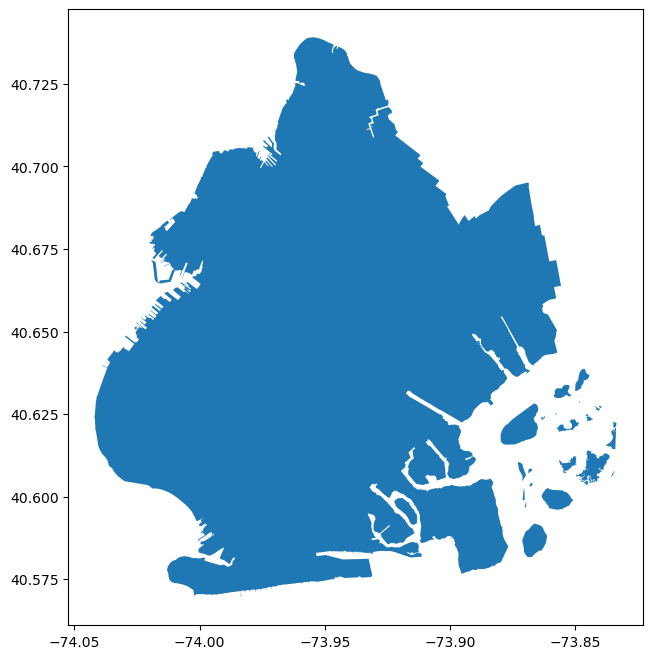

In [7]:
brooklyn = boros[boros['boro_name'] == 'Brooklyn']
brooklyn.plot()

In [8]:
# save as new file 
brooklyn.to_file('../data/transformed/brooklyn.geojson')

#### part II: beford-stuyvesant extent in community districts

In [9]:
# create a new field that removes the demical from boro_cd
cds = cds.to_crs(4326)
cds['cd_int']= cds['boro_cd'].astype(int)
cds

,boro_cd,shape_area,shape_leng,geometry,cd_int
0,308.0,4.560379e+07,38232.886649,"POLYGON ((-73.95829 40.67983, -73.95596 40.679...",308
1,101.0,4.168665e+07,69054.447232,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",101
2,414.0,1.955766e+08,210918.175118,"MULTIPOLYGON (((-73.90972 40.56529, -73.90973 ...",414
3,204.0,5.552214e+07,31358.450463,"POLYGON ((-73.90269 40.84458, -73.90271 40.844...",204
4,501.0,3.772325e+08,153751.224394,"MULTIPOLYGON (((-74.15946 40.64145, -74.15975 ...",501
...,...,...,...,...,...
66,409.0,1.073785e+08,50771.833132,"POLYGON ((-73.81710 40.70403, -73.81697 40.703...",409
67,309.0,4.531498e+07,29932.084039,"POLYGON ((-73.92872 40.66450, -73.92905 40.664...",309
68,355.0,2.614417e+07,23961.395318,"POLYGON ((-73.96257 40.67162, -73.96254 40.671...",355
69,502.0,5.915280e+08,142728.995772,"MULTIPOLYGON (((-74.07347 40.57839, -74.07345 ...",502


In [10]:
# filter for community districts in brooklyn, where cd_int = 301 to 318
# unsure if this is needed for my analysis, filtering this out in case I need later
cds_bk = cds[(cds['cd_int'] >= 301) & (cds['cd_int'] <= 318)]
cds_bk

,boro_cd,shape_area,shape_leng,geometry,cd_int
0,308.0,4.560379e+07,38232.886649,"POLYGON ((-73.95829 40.67983, -73.95596 40.679...",308
12,313.0,8.817725e+07,65778.863073,"POLYGON ((-73.98372 40.59582, -73.98305 40.595...",313
13,311.0,1.032083e+08,51534.144461,"POLYGON ((-73.97299 40.60881, -73.97296 40.608...",311
15,310.0,1.113452e+08,44781.826370,"POLYGON ((-74.03231 40.64404, -74.03201 40.643...",310
19,317.0,9.381843e+07,43327.355081,"POLYGON ((-73.90755 40.65119, -73.90849 40.650...",317
22,306.0,8.550153e+07,82147.932359,"POLYGON ((-74.00174 40.69241, -74.00170 40.692...",306
23,307.0,1.041264e+08,87448.444049,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",307
30,316.0,5.176897e+07,32997.613567,"POLYGON ((-73.90405 40.67922, -73.90349 40.678...",316
39,318.0,2.353990e+08,188007.315169,"MULTIPOLYGON (((-73.91513 40.58627, -73.91510 ...",318
42,314.0,8.217417e+07,49295.212030,"POLYGON ((-73.95630 40.65505, -73.95616 40.653...",314


<Axes: >

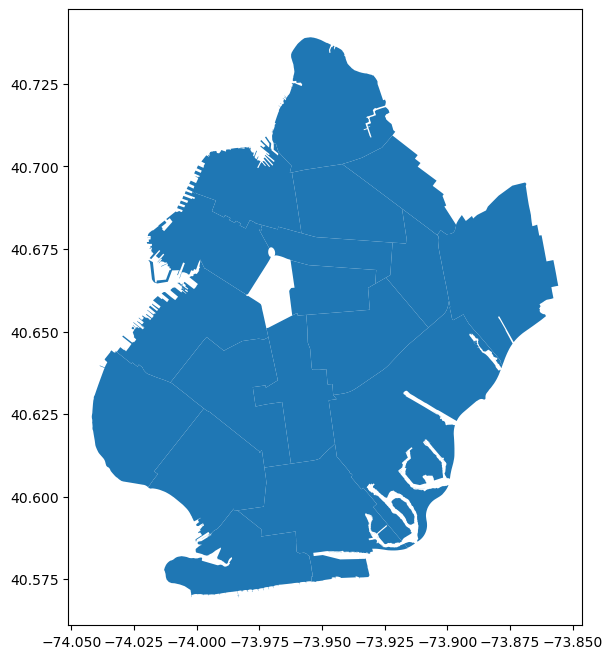

In [11]:
# confirm all BK census tracts have been included 
cds_bk.plot()

In [12]:
# select out bedford-stuyvesant community district, where cd_int = 303
bedstuy = cds_bk[cds_bk['cd_int'] == 303]
bedstuy

,boro_cd,shape_area,shape_leng,geometry,cd_int
61,303.0,7.946168e+07,36213.67539,"POLYGON ((-73.91805 40.68721, -73.91800 40.686...",303


In [13]:
# save as new file 
bedstuy.to_file('../data/transformed/bedstuy.geojson')

In [14]:
# fresh zones and stores will be filtered down when identifying categories in the final section of this notebook

### Cleaning census data: calculating % change, normalizing density

#### part I: median household income / adjusted to 2019 inflation rates

In [15]:
# use most recent census tract (2019) boundaries for visualization

In [16]:
mhhi_19.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
mhhi_19.head()

,GEOID,NAME,variable,estimate,moe,geometry
0,36047057800,"Census Tract 578, Kings County, New York",B19013_001,47466.0,25310.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601..."
1,36047058900,"Census Tract 589, Kings County, New York",B19013_001,85500.0,22226.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732..."
2,36047037000,"Census Tract 370, Kings County, New York",B19013_001,57888.0,13554.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590..."
3,36047019900,"Census Tract 199, Kings County, New York",B19013_001,108333.0,21279.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686..."
4,36047040000,"Census Tract 400, Kings County, New York",B19013_001,52125.0,17412.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598..."


In [18]:
mhhi_11.head()

,GEOID,NAME,variable,estimate,moe,geometry
0,36047029700,"Census Tract 297, Kings County, New York",B19013_001,57284.0,14574.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679..."
1,36047029800,"Census Tract 298, Kings County, New York",B19013_001,47779.0,8344.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597..."
2,36047029900,"Census Tract 299, Kings County, New York",B19013_001,34205.0,14938.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677..."
3,36047030000,"Census Tract 300, Kings County, New York",B19013_001,39306.0,8717.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594..."
4,36047030100,"Census Tract 301, Kings County, New York",B19013_001,42206.0,4870.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676..."


In [19]:
# adjusting for 2019 inflation using (CPI 2019/CPI 2011)
mhhi_11["inc_19"] = mhhi_11["estimate"] * 1.143
mhhi_11.head()

,GEOID,NAME,variable,estimate,moe,geometry,inc_19
0,36047029700,"Census Tract 297, Kings County, New York",B19013_001,57284.0,14574.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679...",65475.612
1,36047029800,"Census Tract 298, Kings County, New York",B19013_001,47779.0,8344.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597...",54611.397
2,36047029900,"Census Tract 299, Kings County, New York",B19013_001,34205.0,14938.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677...",39096.315
3,36047030000,"Census Tract 300, Kings County, New York",B19013_001,39306.0,8717.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594...",44926.758
4,36047030100,"Census Tract 301, Kings County, New York",B19013_001,42206.0,4870.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676...",48241.458


In [20]:
# bring 'inc_19' field into mhhi_19 to calculate change in income 
mhhi_19_11_tb = pd.merge(mhhi_19, mhhi_11[['GEOID', 'inc_19']], how='left', on='GEOID')
mhhi_19_11_tb.head()

,GEOID,NAME,variable,estimate,moe,geometry,inc_19
0,36047057800,"Census Tract 578, Kings County, New York",B19013_001,47466.0,25310.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",73909.809
1,36047058900,"Census Tract 589, Kings County, New York",B19013_001,85500.0,22226.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",99208.971
2,36047037000,"Census Tract 370, Kings County, New York",B19013_001,57888.0,13554.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",64134.873
3,36047019900,"Census Tract 199, Kings County, New York",B19013_001,108333.0,21279.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",64115.442
4,36047040000,"Census Tract 400, Kings County, New York",B19013_001,52125.0,17412.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",45762.291


In [21]:
# calculate change in household income from 2011-2019, adjusted for 2019 inflation 
mhhi_19_11_tb ["inc_change"] = mhhi_19_11_tb ["estimate"] - mhhi_19_11_tb ["inc_19"]
mhhi_19_11_tb.head()

,GEOID,NAME,variable,estimate,moe,geometry,inc_19,inc_change
0,36047057800,"Census Tract 578, Kings County, New York",B19013_001,47466.0,25310.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",73909.809,-26443.809
1,36047058900,"Census Tract 589, Kings County, New York",B19013_001,85500.0,22226.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",99208.971,-13708.971
2,36047037000,"Census Tract 370, Kings County, New York",B19013_001,57888.0,13554.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",64134.873,-6246.873
3,36047019900,"Census Tract 199, Kings County, New York",B19013_001,108333.0,21279.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",64115.442,44217.558
4,36047040000,"Census Tract 400, Kings County, New York",B19013_001,52125.0,17412.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",45762.291,6362.709


<Axes: >

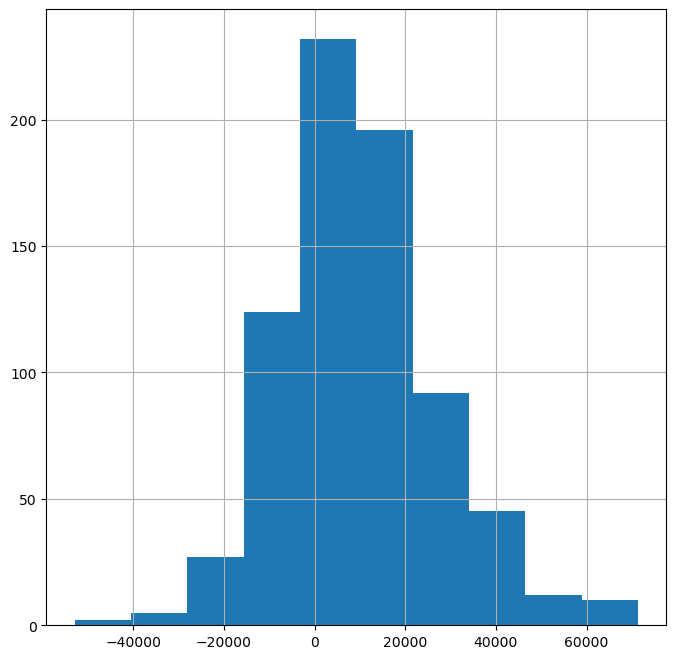

In [22]:
# assess changes. in most census tracts, income increased 
mhhi_19_11_tb['inc_change'].hist()

In [23]:
# create income output to use for census tract indicators merge 
mhhi_output = mhhi_19_11_tb[['GEOID', 'inc_change', 'geometry']].copy()

#### part II: Change in % of white population, using total populations (2011, 2019)

##### part II.A: 2011

In [24]:
yt_11.head()
# see estimate column, white population is represented by counts, not percentages

,GEOID,NAME,variable,estimate,moe,geometry
0,36047029700,"Census Tract 297, Kings County, New York",B02001_002,222.0,128.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679..."
1,36047029800,"Census Tract 298, Kings County, New York",B02001_002,2584.0,454.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597..."
2,36047029900,"Census Tract 299, Kings County, New York",B02001_002,61.0,56.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677..."
3,36047030000,"Census Tract 300, Kings County, New York",B02001_002,1348.0,283.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594..."
4,36047030100,"Census Tract 301, Kings County, New York",B02001_002,24.0,31.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676..."


In [25]:
# create % of white population in 2011 through total population table
tot_pop_11.head()

,GEOID,NAME,variable,estimate,moe,geometry
0,36047029700,"Census Tract 297, Kings County, New York",B01003_001,3440.0,405.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679..."
1,36047029800,"Census Tract 298, Kings County, New York",B01003_001,3671.0,390.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597..."
2,36047029900,"Census Tract 299, Kings County, New York",B01003_001,2318.0,513.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677..."
3,36047030000,"Census Tract 300, Kings County, New York",B01003_001,3049.0,451.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594..."
4,36047030100,"Census Tract 301, Kings County, New York",B01003_001,2575.0,479.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676..."


In [26]:
# combine total population table with white population counts table
pop_yt_11 = pd.merge(yt_11, tot_pop_11[['GEOID', 'estimate']], how='left', on='GEOID')
pop_yt_11.head()

,GEOID,NAME,variable,estimate_x,moe,geometry,estimate_y
0,36047029700,"Census Tract 297, Kings County, New York",B02001_002,222.0,128.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679...",3440.0
1,36047029800,"Census Tract 298, Kings County, New York",B02001_002,2584.0,454.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597...",3671.0
2,36047029900,"Census Tract 299, Kings County, New York",B02001_002,61.0,56.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677...",2318.0
3,36047030000,"Census Tract 300, Kings County, New York",B02001_002,1348.0,283.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594...",3049.0
4,36047030100,"Census Tract 301, Kings County, New York",B02001_002,24.0,31.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676...",2575.0


In [27]:
# calculate % of white population in 2011, where estimate_y is the total population counts 
pop_yt_11["perc_yt"] = (pop_yt_11['estimate_x'] / pop_yt_11['estimate_y']).round(3)
pop_yt_11.head()

,GEOID,NAME,variable,estimate_x,moe,geometry,estimate_y,perc_yt
0,36047029700,"Census Tract 297, Kings County, New York",B02001_002,222.0,128.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679...",3440.0,0.065
1,36047029800,"Census Tract 298, Kings County, New York",B02001_002,2584.0,454.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597...",3671.0,0.704
2,36047029900,"Census Tract 299, Kings County, New York",B02001_002,61.0,56.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677...",2318.0,0.026
3,36047030000,"Census Tract 300, Kings County, New York",B02001_002,1348.0,283.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594...",3049.0,0.442
4,36047030100,"Census Tract 301, Kings County, New York",B02001_002,24.0,31.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676...",2575.0,0.009


##### part II.B: 2019

In [28]:
yt_19.head()

,GEOID,NAME,variable,estimate,moe,geometry
0,36047057800,"Census Tract 578, Kings County, New York",B02001_002,1862.0,360.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601..."
1,36047058900,"Census Tract 589, Kings County, New York",B02001_002,1557.0,179.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732..."
2,36047037000,"Census Tract 370, Kings County, New York",B02001_002,2885.0,351.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590..."
3,36047019900,"Census Tract 199, Kings County, New York",B02001_002,2063.0,285.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686..."
4,36047040000,"Census Tract 400, Kings County, New York",B02001_002,1339.0,282.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598..."


In [29]:
tot_pop_19.head()

,GEOID,NAME,variable,estimate,moe,geometry
0,36047057800,"Census Tract 578, Kings County, New York",B01003_001,3260.0,376.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601..."
1,36047058900,"Census Tract 589, Kings County, New York",B01003_001,1691.0,172.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732..."
2,36047037000,"Census Tract 370, Kings County, New York",B01003_001,4231.0,395.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590..."
3,36047019900,"Census Tract 199, Kings County, New York",B01003_001,3432.0,323.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686..."
4,36047040000,"Census Tract 400, Kings County, New York",B01003_001,3003.0,282.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598..."


In [30]:
pop_yt_19 = pd.merge(yt_19, tot_pop_19[['GEOID', 'estimate']], how='left', on='GEOID')

In [31]:
# calculate % of white population in 2019, where estimate_y is the total population counts 
pop_yt_19["perc_yt"] = (pop_yt_19['estimate_x'] / pop_yt_19['estimate_y']).round(3)
pop_yt_19.head()

,GEOID,NAME,variable,estimate_x,moe,geometry,estimate_y,perc_yt
0,36047057800,"Census Tract 578, Kings County, New York",B02001_002,1862.0,360.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",3260.0,0.571
1,36047058900,"Census Tract 589, Kings County, New York",B02001_002,1557.0,179.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",1691.0,0.921
2,36047037000,"Census Tract 370, Kings County, New York",B02001_002,2885.0,351.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",4231.0,0.682
3,36047019900,"Census Tract 199, Kings County, New York",B02001_002,2063.0,285.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",3432.0,0.601
4,36047040000,"Census Tract 400, Kings County, New York",B02001_002,1339.0,282.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",3003.0,0.446


##### part II.C: 2011-2019 change

In [32]:
# join 2011 and 2019 % yt datasets
yt_19_11 = pd.merge(pop_yt_11, pop_yt_19[['GEOID', 'perc_yt']], how='left', on='GEOID')
yt_19_11.head()

,GEOID,NAME,variable,estimate_x,moe,geometry,estimate_y,perc_yt_x,perc_yt_y
0,36047029700,"Census Tract 297, Kings County, New York",B02001_002,222.0,128.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679...",3440.0,0.065,0.159
1,36047029800,"Census Tract 298, Kings County, New York",B02001_002,2584.0,454.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597...",3671.0,0.704,0.419
2,36047029900,"Census Tract 299, Kings County, New York",B02001_002,61.0,56.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677...",2318.0,0.026,0.096
3,36047030000,"Census Tract 300, Kings County, New York",B02001_002,1348.0,283.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594...",3049.0,0.442,0.303
4,36047030100,"Census Tract 301, Kings County, New York",B02001_002,24.0,31.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676...",2575.0,0.009,0.073


In [33]:
# calculate % change of white population from 2011-2019, where perc_yt_x is 2011 and perc_yt_y is 2019
yt_19_11["yt_change"] = yt_19_11["perc_yt_y"] - yt_19_11["perc_yt_x"]
yt_19_11.head()

,GEOID,NAME,variable,estimate_x,moe,geometry,estimate_y,perc_yt_x,perc_yt_y,yt_change
0,36047029700,"Census Tract 297, Kings County, New York",B02001_002,222.0,128.0,"POLYGON ((-73.93133 40.67937, -73.93290 40.679...",3440.0,0.065,0.159,0.094
1,36047029800,"Census Tract 298, Kings County, New York",B02001_002,2584.0,454.0,"POLYGON ((-73.98575 40.59704, -73.98646 40.597...",3671.0,0.704,0.419,-0.285
2,36047029900,"Census Tract 299, Kings County, New York",B02001_002,61.0,56.0,"POLYGON ((-73.92182 40.67702, -73.92281 40.677...",2318.0,0.026,0.096,0.070
3,36047030000,"Census Tract 300, Kings County, New York",B02001_002,1348.0,283.0,"POLYGON ((-73.98468 40.59366, -73.98602 40.594...",3049.0,0.442,0.303,-0.139
4,36047030100,"Census Tract 301, Kings County, New York",B02001_002,24.0,31.0,"POLYGON ((-73.91081 40.67752, -73.91093 40.676...",2575.0,0.009,0.073,0.064


<Axes: xlabel='yt_change', ylabel='Count'>

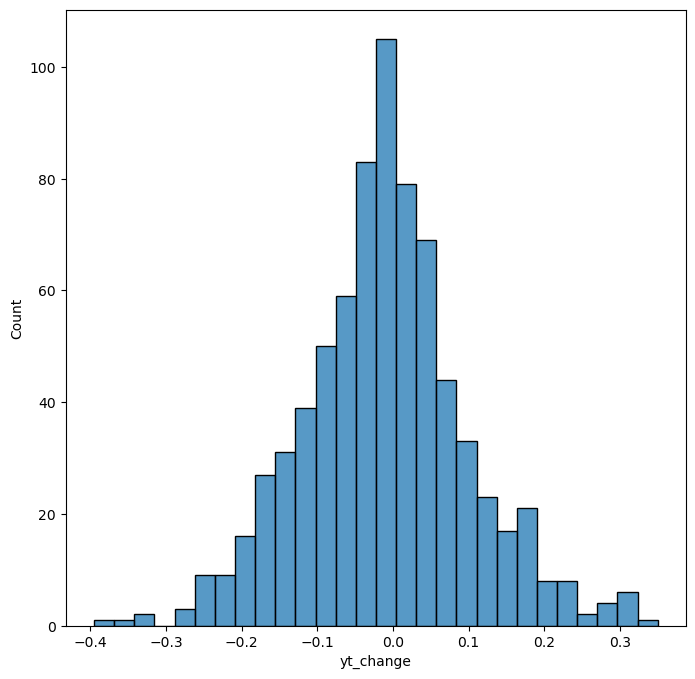

In [34]:
sns.histplot(yt_19_11['yt_change'])

In [35]:
# create white population output to use for census tract indicators merge 
yt_output = yt_19_11[['GEOID', 'yt_change', 'geometry']].copy()

#### Part III: Normalize year structure built (2014+) census data to represent (# of new buildings /per square mile)

##### in order to address nodifiable areal unit problem within census tract boundaries (use CRS: 6933)

##### normalize density via (# of new buildings per census tracts / area of census tract)

In [36]:
# use crs 6933 to calulate area + normalize density. reproject before merging into census tract indicators dataset.
built_19.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
built_19 = built_19.to_crs(6933)

In [38]:
built_19.crs

<Derived Projected CRS: EPSG:6933>
Name: WGS 84 / NSIDC EASE-Grid 2.0 Global
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 86°S and 86°N.
- bounds: (-180.0, -86.0, 180.0, 86.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 Global
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
# calculate areas of each census tract, converted to sq miles
built_19['area'] = built_19['geometry'].area / 2.59e+6
built_19.head()

,GEOID,NAME,variable,estimate,moe,geometry,area
0,36047057800,"Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-7135453.466 4765936.584, -7135337.3...",0.066508
1,36047058900,"Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7134599.442 4778387.332, -7134640.5...",0.181851
2,36047037000,"Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7136669.580 4764707.328, -7136636.8...",0.129682
3,36047019900,"Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-7136848.252 4774212.587, -7136658.3...",0.072937
4,36047040000,"Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7138041.322 4765648.439, -7137992.5...",0.074155


In [40]:
# perform density calculation 
built_19['norm'] = built_19['estimate'] / built_19['area'] 
built_19.head()

,GEOID,NAME,variable,estimate,moe,geometry,area,norm
0,36047057800,"Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-7135453.466 4765936.584, -7135337.3...",0.066508,225.537924
1,36047058900,"Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7134599.442 4778387.332, -7134640.5...",0.181851,0.000000
2,36047037000,"Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7136669.580 4764707.328, -7136636.8...",0.129682,0.000000
3,36047019900,"Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-7136848.252 4774212.587, -7136658.3...",0.072937,315.339872
4,36047040000,"Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-7138041.322 4765648.439, -7137992.5...",0.074155,0.000000


In [41]:
# reproject into 4326 to align with other census tract indicators 
built_19 = built_19.to_crs(4326)
built_19.head()

,GEOID,NAME,variable,estimate,moe,geometry,area,norm
0,36047057800,"Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924
1,36047058900,"Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.181851,0.000000
2,36047037000,"Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",0.129682,0.000000
3,36047019900,"Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.072937,315.339872
4,36047040000,"Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.074155,0.000000


In [42]:
# compare with 'estimate' column, notice difference when normalizing is not accounted for
built_19.explore(column='norm', scheme='fisher_jenks', legend=True)

In [43]:
# create normalized new buildings output to use for census tract indicators merge 
built_output = built_19[['GEOID', 'area', 'norm', 'estimate', 'geometry']].copy()

### Part IV: Merge all census tract indicators into one 'output' layer

In [44]:
# merging first income to race 
output = pd.merge(mhhi_output, yt_output, how='left', on='GEOID')

In [45]:
# then to new buildings  
output = pd.merge(output, built_19, how='left', on='GEOID')
output.head()

,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,estimate,moe,geometry,area,norm
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924
1,36047058900,-13708.971,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.088,"POLYGON ((-73.94568 40.72702, -73.94588 40.727...","Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.181851,0.000000
2,36047037000,-6246.873,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",-0.039,"POLYGON ((-73.96068 40.59160, -73.96062 40.590...","Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",0.129682,0.000000
3,36047019900,44217.558,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.238,"POLYGON ((-73.96445 40.68112, -73.96549 40.681...","Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.072937,315.339872
4,36047040000,6362.709,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.024,"POLYGON ((-73.97504 40.59678, -73.97559 40.596...","Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.074155,0.000000


In [46]:
# update column names
output = output.rename(columns={'estimate': 'num_built'})
output.head()

,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,num_built,moe,geometry,area,norm
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924
1,36047058900,-13708.971,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.088,"POLYGON ((-73.94568 40.72702, -73.94588 40.727...","Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.181851,0.000000
2,36047037000,-6246.873,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",-0.039,"POLYGON ((-73.96068 40.59160, -73.96062 40.590...","Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",0.129682,0.000000
3,36047019900,44217.558,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.238,"POLYGON ((-73.96445 40.68112, -73.96549 40.681...","Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.072937,315.339872
4,36047040000,6362.709,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.024,"POLYGON ((-73.97504 40.59678, -73.97559 40.596...","Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.074155,0.000000


### Create FRESH ZONE and FRESH STORE categories for analysis

#### CATEGORY 1: DEFINE CENSUS TRACTS IN BROOKLYN THAT HAVE/WILL HAVE FRESH DEVELOPMENTS (WHERE has_store = 1)

In [47]:
# select fresh stores within brooklyn census tracts 
fresh_stores = fresh_stores.to_crs(4326)
fresh_census = gpd.sjoin(fresh_stores, output, how='left', predicate='within')
fresh_census.head()

,Address,BBL,Status,TotalSF,ORIG_FID,POINT_X,POINT_Y,geometry,index_right,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,num_built,moe,area,norm
0,2630 Frederick Douglass Boulevard,1.020268e+09,Occupied,"7,688",0,9.998091e+05,237932.800849,POINT (-73.94379 40.81973),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,223 St. Nicholas Avenue,1.019480e+09,Approved,"24,990",1,9.971770e+05,233703.103617,POINT (-73.95330 40.80813),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,2395 Frederick Douglass Boulevard,1.019550e+09,Occupied,"7,341",2,9.981479e+05,235313.096042,POINT (-73.94979 40.81254),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
3,1516 Park Avenue,1.016160e+09,Approved,"7,700",3,9.991880e+05,229282.633136,POINT (-73.94605 40.79599),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
4,2211 Third Avenue,1.017858e+09,Occupied,"12,194",4,1.001584e+06,231024.940181,POINT (-73.93739 40.80077),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# identify number of stores through GEOID, clean columns to get 'num_stores' field
num_stores = fresh_census['GEOID'].value_counts()
num_stores = pd.DataFrame(num_stores).reset_index()
num_stores.columns=['GEOID', 'num_stores']
num_stores

,GEOID,num_stores
0,36047123700,3
1,36047025700,2
2,36047026100,2
3,36047028700,2
4,36047025901,1
5,36047042300,1
6,36047027100,1
7,36047021900,1
8,36047039700,1
9,36047026700,1


In [49]:
# merge num_stores into output
output = pd.merge(output, num_stores, how='left', on='GEOID')
output.head()

,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,num_built,moe,geometry,area,norm,num_stores
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924,NaN
1,36047058900,-13708.971,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.088,"POLYGON ((-73.94568 40.72702, -73.94588 40.727...","Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.181851,0.000000,NaN
2,36047037000,-6246.873,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",-0.039,"POLYGON ((-73.96068 40.59160, -73.96062 40.590...","Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",0.129682,0.000000,NaN
3,36047019900,44217.558,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.238,"POLYGON ((-73.96445 40.68112, -73.96549 40.681...","Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.072937,315.339872,NaN
4,36047040000,6362.709,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.024,"POLYGON ((-73.97504 40.59678, -73.97559 40.596...","Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.074155,0.000000,NaN


In [50]:
# clean NA columns, quanitfy num_stores column 
output['num_stores'] = output['num_stores'].fillna(0)
output['num_stores'].value_counts()

0.0    744
1.0     12
2.0      3
3.0      1
Name: num_stores, dtype: int64

In [51]:
# create binary category (0/1) based on value counts 
# where 0 = NO FRESH DEV and 1 = FRESH DEV 
output['has_store'] = output['num_stores'].apply(lambda x: 1 if x > 0 else 0)
output['has_store'].value_counts()

0    744
1     16
Name: has_store, dtype: int64

In [52]:
# see binary category 'has_store' in census tract output layer
output.head()

,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,num_built,moe,geometry,area,norm,num_stores,has_store
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924,0.0,0
1,36047058900,-13708.971,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.088,"POLYGON ((-73.94568 40.72702, -73.94588 40.727...","Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.181851,0.000000,0.0,0
2,36047037000,-6246.873,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",-0.039,"POLYGON ((-73.96068 40.59160, -73.96062 40.590...","Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",0.129682,0.000000,0.0,0
3,36047019900,44217.558,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.238,"POLYGON ((-73.96445 40.68112, -73.96549 40.681...","Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.072937,315.339872,0.0,0
4,36047040000,6362.709,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.024,"POLYGON ((-73.97504 40.59678, -73.97559 40.596...","Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.074155,0.000000,0.0,0


#### CATEGORY 2: DEFINE CENSUS TRACTS IN BROOKLYN THAT ARE WITHIN A FRESH ZONE (WHERE fresh_zone = 1)

#### 2.a: clip FRESH zones to BK extent, ESPG:4326

In [53]:
# FRESH zones 2019
fresh_zones = gpd.read_file('../data/transformed/fresh_zones.geojson')

In [54]:
fresh_zones.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [55]:
fresh_zones = fresh_zones.to_crs(4326)

In [56]:
fresh_zones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
fresh_zones

,Name,geometry
0,Zoning incentives,"MULTIPOLYGON (((-73.94950 40.83681, -73.94951 ..."
1,Zoning and discretionary tax incentives,"MULTIPOLYGON (((-73.87663 40.81571, -73.87673 ..."
2,Discretionary tax incentives,"MULTIPOLYGON (((-74.11130 40.59815, -74.11128 ..."


<Axes: >

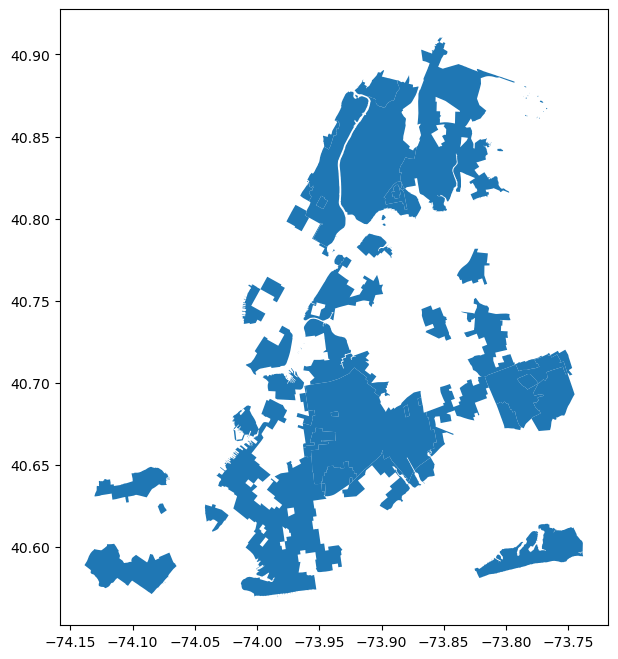

In [58]:
fresh_zones.plot()

<Axes: >

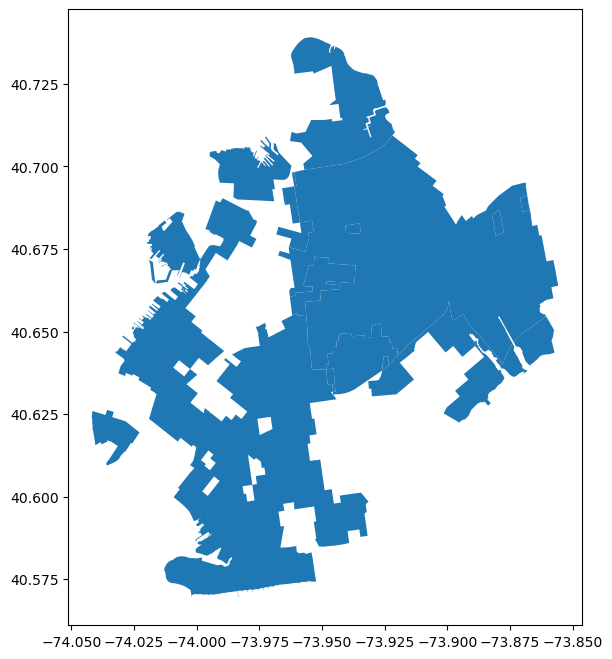

In [59]:
# clip fresh zones to BK boundary
fr_zone_clip = gpd.clip(fresh_zones, brooklyn.geometry)
fr_zone_clip.plot()

In [60]:
# confirm crs alignment prior to spatial join
output.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
# join census tracts that are only within the brooklyn fresh zone boundaries 
cts_in_fresh_zone = gpd.sjoin(output, fr_zone_clip, how="inner", predicate="within")

<Axes: >

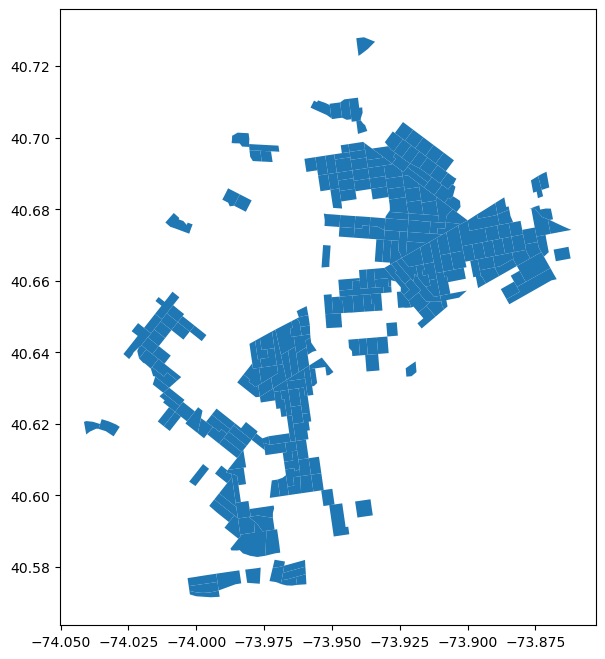

In [62]:
cts_in_fresh_zone.plot()

In [63]:
# create a new field to mark the selected census tracts (where fresh_zone = 1)
cts_in_fresh_zone['fresh_zone'] = 1
cts_in_fresh_zone.head()

,GEOID,inc_change,geometry_x,yt_change,geometry_y,NAME,variable,num_built,moe,geometry,area,norm,num_stores,has_store,index_right,Name,fresh_zone
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924,0.0,0,2,Discretionary tax incentives,1
16,36047044600,12332.436,"POLYGON ((-73.97846 40.61671, -73.97785 40.617...",-0.155,"POLYGON ((-73.97542 40.61597, -73.97548 40.616...","Census Tract 446, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97846 40.61671, -73.97785 40.617...",0.051721,0.000000,0.0,0,2,Discretionary tax incentives,1
17,36047050500,17107.078,"POLYGON ((-73.94547 40.71074, -73.94379 40.710...",-0.012,"POLYGON ((-73.94457 40.70502, -73.94469 40.705...","Census Tract 505, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94547 40.71074, -73.94379 40.710...",0.065407,0.000000,0.0,0,2,Discretionary tax incentives,1
19,36047045800,27671.250,"POLYGON ((-73.96893 40.62923, -73.96848 40.626...",-0.033,"POLYGON ((-73.97092 40.62657, -73.97111 40.627...","Census Tract 458, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96893 40.62923, -73.96848 40.626...",0.069202,0.000000,0.0,0,2,Discretionary tax incentives,1
32,36047021000,-6275.750,"POLYGON ((-74.01000 40.63011, -74.00875 40.629...",-0.028,"POLYGON ((-74.01207 40.62864, -74.01214 40.628...","Census Tract 210, Kings County, New York",B25034_002,13.0,21.0,"POLYGON ((-74.01000 40.63011, -74.00875 40.629...",0.057918,224.456786,0.0,0,2,Discretionary tax incentives,1


In [64]:
# merge cts in fresh zone with entire CT dataset 
output = pd.merge(output, cts_in_fresh_zone, how='left', on='GEOID')

In [65]:
output.head()

,GEOID,inc_change_x,geometry_x_x,yt_change_x,geometry_y_x,NAME_x,variable_x,num_built_x,moe_x,geometry_x,...,num_built_y,moe_y,geometry_y,area_y,norm_y,num_stores_y,has_store_y,index_right,Name,fresh_zone
0,36047057800,-26443.809,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",-0.040,"POLYGON ((-73.94905 40.59748, -73.94997 40.597...","Census Tract 578, Kings County, New York",B25034_002,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",...,15.0,17.0,"POLYGON ((-73.95304 40.60151, -73.95183 40.601...",0.066508,225.537924,0.0,0.0,2.0,Discretionary tax incentives,1.0
1,36047058900,-13708.971,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",0.088,"POLYGON ((-73.94568 40.72702, -73.94588 40.727...","Census Tract 589, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.94419 40.72944, -73.94461 40.732...",...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36047037000,-6246.873,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",-0.039,"POLYGON ((-73.96068 40.59160, -73.96062 40.590...","Census Tract 370, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.96564 40.58889, -73.96530 40.590...",...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36047019900,44217.558,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",0.238,"POLYGON ((-73.96445 40.68112, -73.96549 40.681...","Census Tract 199, Kings County, New York",B25034_002,23.0,26.0,"POLYGON ((-73.96749 40.68652, -73.96552 40.686...",...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36047040000,6362.709,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",0.024,"POLYGON ((-73.97504 40.59678, -73.97559 40.596...","Census Tract 400, Kings County, New York",B25034_002,0.0,12.0,"POLYGON ((-73.97986 40.59855, -73.97935 40.598...",...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# change NA values to 0 to create a binary category (271 out of 760 census tracts are within a FRESH Zone)
output['fresh_zone'] = output['fresh_zone'].fillna(0)
output['fresh_zone'].value_counts()

0.0    490
1.0    270
Name: fresh_zone, dtype: int64

In [67]:
output.columns

Index(['GEOID', 'inc_change_x', 'geometry_x_x', 'yt_change_x', 'geometry_y_x',
       'NAME_x', 'variable_x', 'num_built_x', 'moe_x', 'geometry_x', 'area_x',
       'norm_x', 'num_stores_x', 'has_store_x', 'inc_change_y', 'geometry_x_y',
       'yt_change_y', 'geometry_y_y', 'NAME_y', 'variable_y', 'num_built_y',
       'moe_y', 'geometry_y', 'area_y', 'norm_y', 'num_stores_y',
       'has_store_y', 'index_right', 'Name', 'fresh_zone'],
      dtype='object')

In [68]:
# remove duplicate geometry fields, preserve geometry_x_x
output = output.drop(['geometry_y_x', 'geometry_x', 'geometry_x_y', 'geometry_y_y', 'geometry_y'], axis=1)

In [69]:
print(output.dtypes)

GEOID             object
inc_change_x     float64
geometry_x_x    geometry
yt_change_x      float64
NAME_x            object
variable_x        object
num_built_x      float64
moe_x            float64
area_x           float64
norm_x           float64
num_stores_x     float64
has_store_x        int64
inc_change_y     float64
yt_change_y      float64
NAME_y            object
variable_y        object
num_built_y      float64
moe_y            float64
area_y           float64
norm_y           float64
num_stores_y     float64
has_store_y      float64
index_right      float64
Name              object
fresh_zone       float64
dtype: object


In [70]:
output['has_store_x'] = output['has_store_x'].astype('float64')

In [71]:
print(output.dtypes)

GEOID             object
inc_change_x     float64
geometry_x_x    geometry
yt_change_x      float64
NAME_x            object
variable_x        object
num_built_x      float64
moe_x            float64
area_x           float64
norm_x           float64
num_stores_x     float64
has_store_x      float64
inc_change_y     float64
yt_change_y      float64
NAME_y            object
variable_y        object
num_built_y      float64
moe_y            float64
area_y           float64
norm_y           float64
num_stores_y     float64
has_store_y      float64
index_right      float64
Name              object
fresh_zone       float64
dtype: object


In [72]:
output = output.set_geometry('geometry_x_x')

In [73]:
output.to_file('../data/final/brooklyn_inds.geojson')

#### CATEGORY 3: DEFINE CENSUS TRACTS IN BEDFORD-STUYVESANT THAT HAVE/WILL HAVE FRESH DEVELOPMENTS

In [74]:
# create an additional layer of all categories clipped to bed-stuy extent 

In [75]:
bedstuy

,boro_cd,shape_area,shape_leng,geometry,cd_int
61,303.0,7.946168e+07,36213.67539,"POLYGON ((-73.91805 40.68721, -73.91800 40.686...",303


<Axes: >

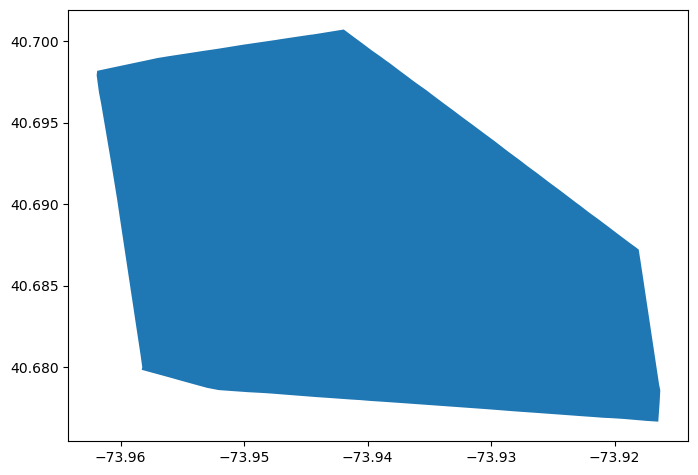

In [76]:
bedstuy.plot()

In [77]:
# confirm crs prior to spatial join
bedstuy.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [78]:
output.columns

Index(['GEOID', 'inc_change_x', 'geometry_x_x', 'yt_change_x', 'NAME_x',
       'variable_x', 'num_built_x', 'moe_x', 'area_x', 'norm_x',
       'num_stores_x', 'has_store_x', 'inc_change_y', 'yt_change_y', 'NAME_y',
       'variable_y', 'num_built_y', 'moe_y', 'area_y', 'norm_y',
       'num_stores_y', 'has_store_y', 'index_right', 'Name', 'fresh_zone'],
      dtype='object')

In [79]:
bedstuy = bedstuy.set_geometry('geometry')

In [80]:
# clip merged census tract indicators to bed-stuy extent
output_bedstuy = gpd.clip(output, bedstuy.geometry)
output_bedstuy.head()

,GEOID,inc_change_x,geometry_x_x,yt_change_x,NAME_x,variable_x,num_built_x,moe_x,area_x,norm_x,...,variable_y,num_built_y,moe_y,area_y,norm_y,num_stores_y,has_store_y,index_right,Name,fresh_zone
618,36047030500,25923.779,"POLYGON ((-73.95531 40.67927, -73.95532 40.679...",0.240,"Census Tract 305, Kings County, New York",B25034_002,95.0,53.0,0.117968,805.300900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
62,36047022100,6242.776,"POLYGON ((-73.95531 40.67927, -73.95300 40.678...",0.222,"Census Tract 221, Kings County, New York",B25034_002,26.0,24.0,0.064962,400.232160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
627,36047031500,18519.973,"POLYGON ((-73.94968 40.67857, -73.94691 40.678...",0.297,"Census Tract 315, Kings County, New York",B25034_002,0.0,12.0,0.069708,0.000000,...,B25034_002,0.0,12.0,0.069708,0.0,0.0,0.0,1.0,Zoning and discretionary tax incentives,1.0
227,36047024700,4580.187,"POLYGON ((-73.94956 40.68039, -73.94627 40.680...",0.163,"Census Tract 247, Kings County, New York",B25034_002,5.0,10.0,0.071271,70.155168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
605,36047022700,50707.211,"POLYGON ((-73.95611 40.68333, -73.95395 40.683...",0.164,"Census Tract 227, Kings County, New York",B25034_002,224.0,85.0,0.091389,2451.057497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


<Axes: >

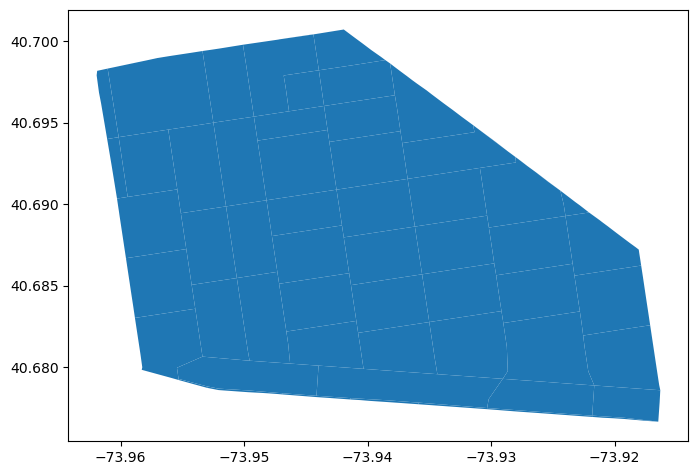

In [81]:
output_bedstuy.plot()

In [82]:
output_bedstuy.to_file('../data/final/bedstuy_inds.geojson')